<a href="https://colab.research.google.com/github/mayssajeb/Reconnaissance-Signature/blob/master/Extraction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse
from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

E: Package 'python-software-properties' has no installation candidate
Selecting previously unselected package google-drive-ocamlfuse.
(Reading database ... 130942 files and directories currently installed.)
Preparing to unpack .../google-drive-ocamlfuse_0.7.6-0ubuntu1~ubuntu18.04.1_amd64.deb ...
Unpacking google-drive-ocamlfuse (0.7.6-0ubuntu1~ubuntu18.04.1) ...
Setting up google-drive-ocamlfuse (0.7.6-0ubuntu1~ubuntu18.04.1) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
··········
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=ht

In [0]:
!mkdir -p drive
!google-drive-ocamlfuse drive


In [0]:
import os
os.chdir('/content/drive/Stage_Wevioo_VérififcationSignature/Stage_Wevioo')

In [0]:
!ls

 010_24.png		   SigWIcomp2015-Data
 Base_Cheque		   Testdata_SigComp2011
'BHSig260 - Copie'	   test.ipynb
 Dataset_Signature.h5	   trainingSet
 drive			   tranfer_20ep_l2+dropout.h5
 Extraction.ipynb	   VerificationSignature_Final.ipynb
 Extract.ipynb		   Verif_Signature.ipynb
 ModelInception_v3.ipynb


In [0]:
# reference: https://www.pyimagesearch.com/2014/09/01/build-kick-ass-mobile-document-scanner-just-5-minutes/
# import the necessary packages
import numpy as np
import cv2

def order_points(pts):
	# initialzie a list of coordinates that will be ordered
	# such that the first entry in the list is the top-left,
	# the second entry is the top-right, the third is the
	# bottom-right, and the fourth is the bottom-left
	rect = np.zeros((4, 2), dtype = "float32")

	# the top-left point will have the smallest sum, whereas
	# the bottom-right point will have the largest sum
	s = pts.sum(axis = 1)
	rect[0] = pts[np.argmin(s)]
	rect[2] = pts[np.argmax(s)]

	# now, compute the difference between the points, the
	# top-right point will have the smallest difference,
	# whereas the bottom-left will have the largest difference
	diff = np.diff(pts, axis = 1)
	rect[1] = pts[np.argmin(diff)]
	rect[3] = pts[np.argmax(diff)]

	# return the ordered coordinates
	return rect

def four_point_transform(image, pts):
	# obtain a consistent order of the points and unpack them
	# individually
	rect = order_points(pts)
	(tl, tr, br, bl) = rect

	# compute the width of the new image, which will be the
	# maximum distance between bottom-right and bottom-left
	# x-coordiates or the top-right and top-left x-coordinates
	widthA = np.sqrt(((br[0] - bl[0]) ** 2) + ((br[1] - bl[1]) ** 2))
	widthB = np.sqrt(((tr[0] - tl[0]) ** 2) + ((tr[1] - tl[1]) ** 2))
	maxWidth = max(int(widthA), int(widthB))

	# compute the height of the new image, which will be the
	# maximum distance between the top-right and bottom-right
	# y-coordinates or the top-left and bottom-left y-coordinates
	heightA = np.sqrt(((tr[0] - br[0]) ** 2) + ((tr[1] - br[1]) ** 2))
	heightB = np.sqrt(((tl[0] - bl[0]) ** 2) + ((tl[1] - bl[1]) ** 2))
	maxHeight = max(int(heightA), int(heightB))

	# now that we have the dimensions of the new image, construct
	# the set of destination points to obtain a "birds eye view",
	# (i.e. top-down view) of the image, again specifying points
	# in the top-left, top-right, bottom-right, and bottom-left
	# order
	dst = np.array([
		[0, 0],
		[maxWidth - 1, 0],
		[maxWidth - 1, maxHeight - 1],
		[0, maxHeight - 1]], dtype = "float32")

	# compute the perspective transform matrix and then apply it
	M = cv2.getPerspectiveTransform(rect, dst)
	warped = cv2.warpPerspective(image, M, (maxWidth, maxHeight))

	# return the warped image
	return warped


In [0]:
from skimage.filters import threshold_local
import numpy as np
import argparse
import cv2
import imutils

def dewarp_book(image):
	# get input image ration to keep best output resolution quality
	ratio = image.shape[0] / 500.0
	# copy source image for filter operations
	orig = image.copy()
	# resize the input image	
	image = imutils.resize(image, height = 500)

	# convert rgb input image to grayscale
	gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
	gray = cv2.GaussianBlur(gray, (5, 5), 0)

	# sigma parameter is used for automatic Canny edge detection
	sigma=0.33

	# compute the median of the single channel pixel intensities
	v = np.median(image)

	# apply automatic Canny edge detection using the computed median
	lower = int(max(0, (1.0 - sigma) * v))
	upper = int(min(255, (1.0 + sigma) * v))
	edged = cv2.Canny(image, lower, upper)

	# perform dilate morphological filter to connect teh image pixel points
	'''kernel = np.ones((5,5),np.uint8)
	edged = cv2.dilate(edged,kernel,iterations = 1)'''

	# find contours
	cnts = cv2.findContours(edged.copy(), cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
	cnts = imutils.grab_contours(cnts)
	cnts = sorted(cnts, key = cv2.contourArea, reverse = True)[:5]
	# loop over the contours
	for c in cnts:
		peri = cv2.arcLength(c, True)
		approx = cv2.approxPolyDP(c, 0.02 * peri, True)

		if len(approx) == 4:
			screenCnt = approx
			break
	# apply the four point transform for book dewarping
	warped = four_point_transform(orig, screenCnt.reshape(4, 2) * ratio)
	return warped


In [0]:
import cv2

def unsharpen_mask(image):	
	# Effectuer un filtre GaussianBlur pour l'utiliser dans un masque non affaiblissant
	gaussian_3 = cv2.GaussianBlur(image, (9,9), 10.0)
	# calcule la somme pondérée de deux tableaux (image source et filtre Flou gaussien) pour obtenir un masque non flou
	unsharp_image = cv2.addWeighted(image, 1.5, gaussian_3, -0.5, 0, image)
	# retourne l'image non affilée	
 
	return unsharp_image

In [0]:

import cv2
import numpy as np
from skimage import measure
from skimage.measure import label, regionprops
from skimage.color import label2rgb
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from scipy import ndimage
from skimage import morphology

def extract_signature(source_image):

	# read the input image
	img = source_image
	img = cv2.threshold(img, 127, 255, cv2.THRESH_BINARY)[1]  # ensure binary

	# connected component analysis by scikit-learn framework
	blobs = img > img.mean()
	blobs_labels = measure.label(blobs, background=1)
	image_label_overlay = label2rgb(blobs_labels, image=img)

	fig, ax = plt.subplots(figsize=(10, 6))

	
	# plot the connected components (for debugging)
	ax.imshow(image_label_overlay)
	ax.set_axis_off()
	plt.tight_layout()
	plt.show()
	

	the_biggest_component = 0
	total_area = 0
	counter = 0
	average = 0.0
	for region in regionprops(blobs_labels):
		if region.area>10:
		    total_area = total_area + region.area
		    counter = counter + 1
		#print region.area # (for debugging)
		# take regions with large enough areas
		if region.area >= 250:
		    if (region.area > the_biggest_component):
		        the_biggest_component = region.area

	average = (total_area/counter)
	print ("the_biggest_component: " + str(the_biggest_component))
	print ("average: " + str(average))

	# experimental-based ratio calculation, modify it for your cases 
	# a4_constant is used as a threshold value to remove connected pixels are smaller than a4_constant for A4 size scanned documents
	a4_constant = (((average/84.0)*250.0)+100)*1.5
	print ("a4_constant: " + str(a4_constant))

	# remove the connected pixels are smaller than a4_constant
	b = morphology.remove_small_objects(blobs_labels, a4_constant)
	# save the the pre-version which is the image is labelled with colors as considering connected components
	plt.imsave('pre_version.png', b)

	# read the pre-version
	img = cv2.imread('pre_version.png', 0)
	# ensure binary
	img = cv2.threshold(img, 0, 255,cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]
	# save the the result
	#cv2.imwrite("output.png", img)
	return img


In [0]:
import cv2
 
contrast = 0
brightness = 0

# fonction du Contraste lumineux
def funcBrightContrast(img, bright=0):
    effect = apply_brightness_contrast(img,bright,contrast)
    # save the final output image
    #cv2.imwrite("./outputs/" + output_img, effect)
    return effect

# fonction pour effectuer la correction de couleur
def apply_brightness_contrast(input_img, brightness = 255, contrast = 127):
    brightness = 80
    contrast = 60
 
    # if brightness does not equal 0
    if brightness != 0:
        if brightness > 0:
            shadow = brightness
            highlight = 255
        else:
            shadow = 0
            highlight = 255 + brightness
        # calculating the alpha value
        alpha_b = (highlight - shadow)/255
        # set the gamma value
        gamma_b = shadow
        # to change the brightness in order to use the cv2.addWeighted()
        buf = cv2.addWeighted(input_img, alpha_b, input_img, 0, gamma_b)
    else:
        buf = input_img.copy()
    # if contrast does not equal 0
    if contrast != 0:
        f = float(131 * (contrast + 127)) / (127 * (131 - contrast))
        # calculating the alpha value
        alpha_c = f
        # set the gamma value
        gamma_c = 127*(1-f)
        # to change the contrast in order to use the cv2.addWeighted()
        buf = cv2.addWeighted(buf, alpha_c, buf, 0, gamma_c)
    # return color corrected image
    return buf


In [0]:
 def display_one(a, title1 = " Original-Transformé en niveau de gris"):
    plt.imshow(a,cmap='gray'), plt.title(title1)
    plt.xticks([]), plt.yticks([])
    plt.show()

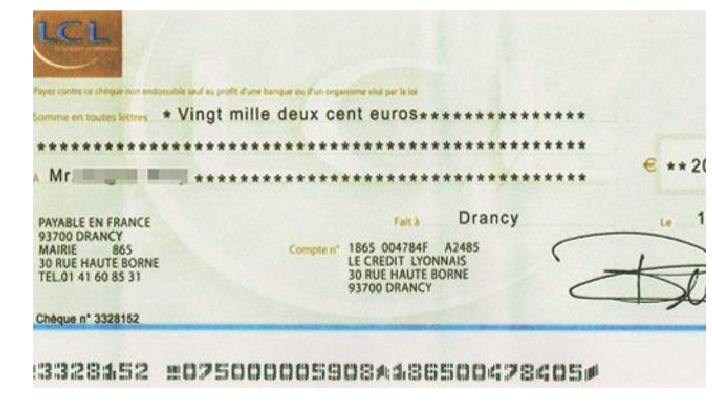

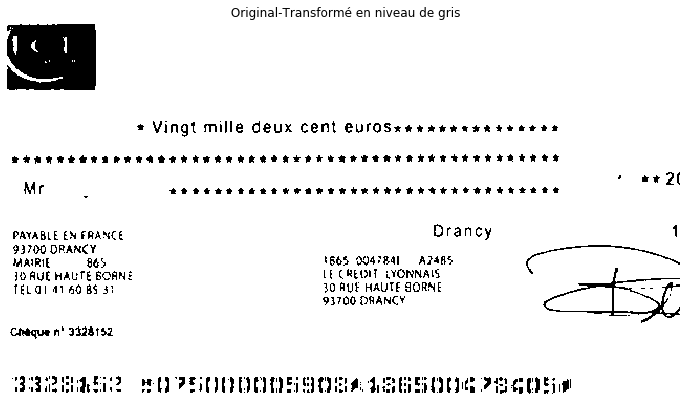

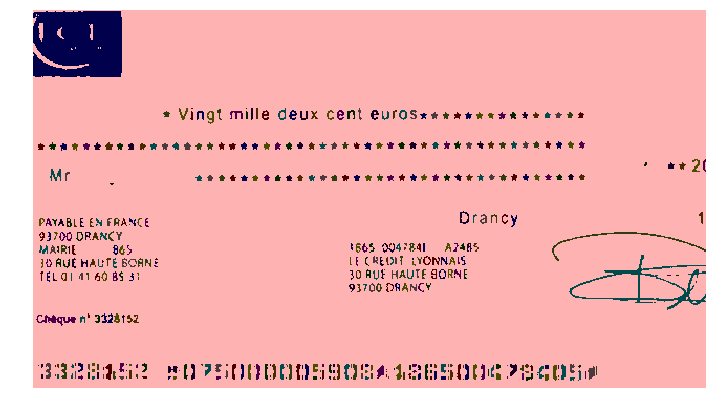

the_biggest_component: 4903
average: 44.7530487804878
a4_constant: 349.7903963414634
- step2 (signature extractor): OK
- step3 (unsharpening mask): OK
- step4 (color correlation): OK


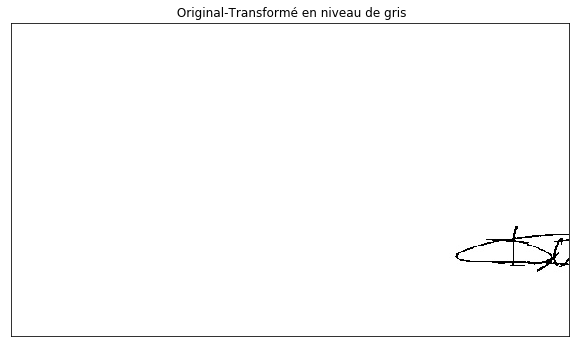

<Figure size 432x288 with 0 Axes>

In [0]:
import cv2


source_image = cv2.imread("Base_Cheque/chequeMay.jpg")
fig, ax = plt.subplots(figsize=(10, 6))
ax.imshow(source_image)
ax.set_axis_off()
plt.tight_layout()
plt.show()


################################
img = cv2.imread('Base_Cheque/chequeMay.jpg', 0)
img = cv2.threshold(img, 127, 255, cv2.THRESH_BINARY)[1]  # ensure binary
fig, ax = plt.subplots(figsize=(10, 6))
ax.imshow(img)
ax.set_axis_off()
plt.tight_layout()
display_one(img)

######################

img = 0
'''try:	
	# read the source input image and call the dewarp_book function to perform cropping with the margin and book dewarping
	img = dewarp_book(source_image)
	cv2.imwrite("step 1 - page_dewarped.jpg", img)
	print("- step1 (cropping with the argins + book dewarpping): OK")
except Exception as e:
	print("type error: " + str(e))
	print("ERROR IN CROPPING & BOOK DEWARPING! PLEASE CHECK LIGTHNING, SHADOW, ZOOM LEVEL AND ETC. OF YOUR INPUT BOOK IMAGE!")'''
try:
	# call the unsharpen_mask method to perform signature extraction
	img = extract_signature(cv2.cvtColor(source_image, cv2.COLOR_BGR2GRAY))
	image2=cv2.imwrite("step 2 - signature_extracted.jpg", img) 
	print("- step2 (signature extractor): OK")
except Exception as e:
	print("type error: " + str(e))
	print("ERROR IN SIGNATURE EXTRACTION! PLEASE CHECK LIGTHNING, SHADOW, ZOOM LEVEL AND ETC. OF YOUR INPUT BOOK IMAGE!")
try:
	# call the unsharpen_mask method to perform unsharpening mask
	unsharpen_mask(img)
  
	cv2.imwrite("step 3 - unsharpen_mask.jpg", img)
	print("- step3 (unsharpening mask): OK")
except Exception as e:
	print("type error: " + str(e))
	print("ERROR IN BOOK UNSHARPING MASK! PLEASE CHECK LIGTHNING, SHADOW, ZOOM LEVEL AND ETC. OF YOUR INPUT BOOK IMAGE!")
try:
	# call the funcBrightContrast method to perform color correction
	img = funcBrightContrast(img)
	cv2.imwrite("Stage_Wevioo/step 4 - color_correlated.jpg", img)
  
	print("- step4 (color correlation): OK")
except Exception as e:
	print("type error: " + str(e))
	print("ERROR IN BOOK COLOR CORRELATION! PLEASE CHECK LIGTHNING, SHADOW, ZOOM LEVEL AND ETC. OF YOUR INPUT BOOK IMAGE!")

cv2.imwrite("output.jpg", img)
imgFinal = cv2.imread('output.jpg',0)
fig, ax = plt.subplots(figsize=(10, 6))
display_one(imgFinal)
ax.set_axis_off()
plt.tight_layout()
plt.show()

In [0]:
!pip install pytesseract

     |████████████████████████████████| 174kB 4.9MB/s 
  Stored in directory: /root/.cache/pip/wheels/cd/4a/30/998e01b892300ba0ccce7b806b6e889794605a384dac81a49a
Successfully built pytesseract


In [0]:
!pip install tesseract 